# Abstract

본 연구는 학생들의 SNS 사용과 관련된 행동/심리적 요인이 중독 수준에 미치는 영향을 분석을 목적으로 수행되었다. 본 연구는 SNS 일일 사용 시간, 수면 시간, 정신 건강 점수, SNS 관련 갈등 경험, 나이 등의 변수가 소셜미디어 중독 점수에 미치는 영향을 종합적으로 검토하는 방향으로 수행되었으며, 방법론으로는 OLS 회귀, 범주형 변수 포함 회귀, GMM 클러스터링, VIF 분석, ANOVA가 사용되었다.
결론적으로, 정신 건강 점수와 SNS 갈등 경험이 중독에 가장 유의미한 영향을 주는 것으로 파악됐다. 또한 중독 수준이 높아질수록 해당 요인의 영향력이 감소하였으며, 수면 시간은 중독 점수와 음의 상관이 존재함을 파악했다. 

# Introduction

## Research Question

> "학생들의 일일 소셜미디어 사용 시간, 수면 시간, 정신건강 점수, 그리고 소셜미디어 관련 갈등 경험은 소셜미디어 중독 점수에 어떤 영향을 미치는가?"

## Hyphothesis

- **귀무가설 (H0)**: 모든 독립 변수는 중독 점수에 유의미한 영향을 미치지 않는다.
- **대립가설 (H1)**: 하나 이상의 독립 변수는 중독 점수에 유의미한 영향을 미친다.

In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from sklearn.mixture import GaussianMixture
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/Students Social Media Addiction.csv")

# Research Method

## Data
- **샘플 수**: 705명
- **주요 변수**
  - 종속 변수: `Addicted_Score` (소셜미디어 중독 점수)
  - 주요 독립 변수: `Avg_Daily_Usage_Hours`, `Sleep_Hours_Per_Night`, `Mental_Health_Score`, `Conflicts_Over_Social_Media`, `Age` 등

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Country                       705 non-null    object 
 5   Avg_Daily_Usage_Hours         705 non-null    float64
 6   Most_Used_Platform            705 non-null    object 
 7   Affects_Academic_Performance  705 non-null    object 
 8   Sleep_Hours_Per_Night         705 non-null    float64
 9   Mental_Health_Score           705 non-null    int64  
 10  Relationship_Status           705 non-null    object 
 11  Conflicts_Over_Social_Media   705 non-null    int64  
 12  Addicted_Score                705 non-null    int64  
dtypes: fl

## Correlation Analysis
- 주요 변수 간 피어슨 상관계수 계산
- `Addicted_Score`와 높은 상관을 가진 변수:
  - `Mental_Health_Score`: **-0.945** (강한 음의 상관)
  - `Conflicts_Over_Social_Media`: **+0.934**
  - `Avg_Daily_Usage_Hours`: **+0.832**

In [3]:
numeric_vars = [
    'Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
    'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Addicted_Score'
]
correlation_matrix = df[numeric_vars].corr()

correlation_matrix

,Age,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Mental_Health_Score,Conflicts_Over_Social_Media,Addicted_Score
Age,1.000000,-0.113682,0.125265,0.160278,-0.184482,-0.166396
Avg_Daily_Usage_Hours,-0.113682,1.000000,-0.790582,-0.801058,0.804582,0.832000
Sleep_Hours_Per_Night,0.125265,-0.790582,1.000000,0.707439,-0.677266,-0.764858
Mental_Health_Score,0.160278,-0.801058,0.707439,1.000000,-0.893572,-0.945051
Conflicts_Over_Social_Media,-0.184482,0.804582,-0.677266,-0.893572,1.000000,0.933586
Addicted_Score,-0.166396,0.832000,-0.764858,-0.945051,0.933586,1.000000


## OLS Regression

### 모델 1: 수치형 변수만 포함한 회귀
- 설명력 (R²): 0.945
- 유의미 변수:
  - `Mental_Health_Score` (p < 0.001)
  - `Conflicts_Over_Social_Media` (p < 0.001)
  - `Sleep_Hours_Per_Night` (p < 0.001)

### 모델 2: 범주형 변수 포함 (Gender, Country, Platform 등)
- 설명력 (R²): 0.982
- 유의미 변수:
  - 학업 성과에 영향을 준다고 답한 경우 (`+0.66`)
  - TikTok, Snapchat 사용자 (정의 영향)
  - WhatsApp, LINE 사용자 (부의 영향)

In [4]:
# 모델 1: 수치형 변수만 포함한 회귀모형
model1_features = ['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
                   'Mental_Health_Score', 'Conflicts_Over_Social_Media']
y1, X1 = patsy.dmatrices('Addicted_Score ~ ' + ' + '.join(model1_features), data=df, return_type='dataframe')
model1 = sm.OLS(y1, X1).fit()

# 모델 2: 범주형 변수 포함한 회귀모형
# 범주형 변수는 자동으로 더미 처리됨
formula_model2 = ('Addicted_Score ~ Age + Avg_Daily_Usage_Hours + Sleep_Hours_Per_Night + '
                  'Mental_Health_Score + Conflicts_Over_Social_Media + '
                  'C(Gender) + C(Academic_Level) + C(Country) + '
                  'C(Most_Used_Platform) + C(Affects_Academic_Performance) + '
                  'C(Relationship_Status)')

y2, X2 = patsy.dmatrices(formula_model2, data=df, return_type='dataframe')
model2 = sm.OLS(y2, X2).fit()

print(model1.summary())
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:         Addicted_Score   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     2380.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:31:37   Log-Likelihood:                -306.26
No. Observations:                 705   AIC:                             624.5
Df Residuals:                     699   BIC:                             651.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## VIF Evaluation
- 모델 1: 모든 변수 VIF < 10 (안정적)
- 모델 2: 국가 더미 변수와 SNS 플랫폼 더미 중 다수 VIF > 30 → **다중공선성 존재**

In [6]:
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# 모델 1의 VIF
vif_model1 = compute_vif(X1)

# 모델 2의 VIF
vif_model2 = compute_vif(X2)

In [7]:
vif_model1

,Variable,VIF
0,Intercept,784.929070
1,Age,1.040674
2,Avg_Daily_Usage_Hours,4.292493
3,Sleep_Hours_Per_Night,2.789703
4,Mental_Health_Score,5.652000
5,Conflicts_Over_Social_Media,5.646419


In [8]:
vif_model2[vif_model2["VIF"] >= 10]

,Variable,VIF
0,Intercept,4126.759655
8,C(Country)[T.Australia],20.894388
13,C(Country)[T.Bangladesh],30.179427
19,C(Country)[T.Brazil],13.512929
21,C(Country)[T.Canada],49.472485
23,C(Country)[T.China],35.952642
29,C(Country)[T.Denmark],39.242054
33,C(Country)[T.Finland],12.774641
34,C(Country)[T.France],39.252159
36,C(Country)[T.Germany],20.894008


## Optimal OLS Regression

- 회귀 모형: Addicted_Score ~ Sleep_Hours_Per_Night + Mental_Health_Score + Conflicts_Over_Social_Media
- 회귀 계수: 
    - Sleep_Hours_Per_Night	: `21.118`
    - Mental_Health_Score : `71.619`
    - Conflicts_Over_Social_Media: `58.084`
- 유의 확률:
    - Sleep_Hours_Per_Night	: `p<0.0001***`
    - Mental_Health_Score : `p<0.0001***`
    - Conflicts_Over_Social_Media: `p<0.0001***`

In [9]:
model1_formula = 'Addicted_Score ~ Sleep_Hours_Per_Night + Mental_Health_Score + Conflicts_Over_Social_Media'
model1_formula_fit = sm.OLS.from_formula(model1_formula, data=df).fit()

anova_results_fixed = sm.stats.anova_lm(model1_formula_fit, typ=2)
anova_results_fixed

,sum_sq,df,F,PR(>F)
Sleep_Hours_Per_Night,21.117762,1.0,150.226194,1.977604e-31
Mental_Health_Score,71.618590,1.0,509.475774,3.266240e-85
Conflicts_Over_Social_Media,58.083739,1.0,413.192413,1.438482e-72
Residual,98.541744,701.0,NaN,NaN


## Model Diagnostics

### 1. Residual Analysis

최종 OLS 회귀 모형 (`Addicted_Score ~ Sleep + Mental_Health + Conflict`)의 적합도를 검토하기 위해 잔차 분석을 수행하였다.

| 그래프 유형 | 해석 |
|-------------|------|
| **Q–Q Plot** | 잔차의 정규성 가정을 시각적으로 검토한 결과, 대부분의 점들이 45도 대각선을 어긋남. 이를 통해 잔차 정규성이 기각됐음을 알 수 있음 |
| **Residuals vs Fitted Plot** | 잔차와 예측값 간의 산점도 분석 결과, **특정한 패턴이 보이지 않아 선형성 가정 충족**. 또한, 잔차의 분산이 일정하게 퍼져 있어 **등분산성(homoscedasticity) 가정도 만족**하는 것으로 보임. |
| **Scale-Location Plot** | 제곱근한 표준화 잔차와 예측값 사이의 관계에서 점들이 무작위로 분포되어 있어 **등분산성이 다시 한 번 확인**됨. |
| **Cook’s Distance Plot** | 영향력 높은 관측치를 확인하기 위해 Cook’s Distance를 시각화한 결과, 기준선(4/n)을 초과하는 관측치가 많이 관측됨. **특별히 통제해야 할 이상치(outlier)가 상당수**. |

**→ 결론**: 전반적으로 회귀모형은 **잔차 정규성이 기각되어,** 추가적인 분석에 대한 고려 필요

---

### 2. Histogram of Addicted_Score

종속 변수인 `Addicted_Score`에 대한 분포를 시각화하였다.

- **형태**: 히스토그램은 **2개의 분포가 겹친 형태**를 띔.
- **해석**:
  - 중독 점수읩 분포는 쌍봉 형태로, **2개의 분포로 분리**해서 분석하는 것이 가능할 것으로 추측.

**→ 결론**: 종속 변수를 2개의 분포로 분리하여 분석하는 작업 필요


In [10]:
def resid_plot(model):
    resid = model.resid                               
    fitted = model.fittedvalues
    std_resid = model.get_influence().resid_studentized_internal
    cooks_d = model.get_influence().cooks_distance[0]
    
    # (a) Q–Q plot ― 정규성
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    qqplot(resid, line="45", ax=ax[0, 0])
    ax[0, 0].set_title("Q-Q Plot")

    # (b) Residuals vs Fitted ― 선형성·등분산성
    ax[0, 1].scatter(fitted, resid, alpha=0.7)
    ax[0, 1].axhline(0, ls="--")
    ax[0, 1].set_xlabel("Fitted values")
    ax[0, 1].set_ylabel("Residuals")
    ax[0, 1].set_title("Residuals vs Fitted")

    # (c) Scale–Location (√|표준화 잔차| vs Fitted) ― 등분산성
    ax[1, 0].scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.7)
    ax[1, 0].set_xlabel("Fitted values")
    ax[1, 0].set_ylabel("√|Standardized Residuals|")
    ax[1, 0].set_title("Scale-Location")

    # (d) Cook’s Distance ― 영향력 관측치
    ax[1, 1].stem(range(len(cooks_d)), cooks_d, markerfmt=",")
    ax[1, 1].set_xlabel("Observation index")
    ax[1, 1].set_ylabel("Cook’s Distance")
    ax[1, 1].set_title("Cook’s Distance")
    # 기준선: 4/n
    ax[1, 1].axhline(4 / len(df), ls="--")

    plt.tight_layout()
    plt.show()

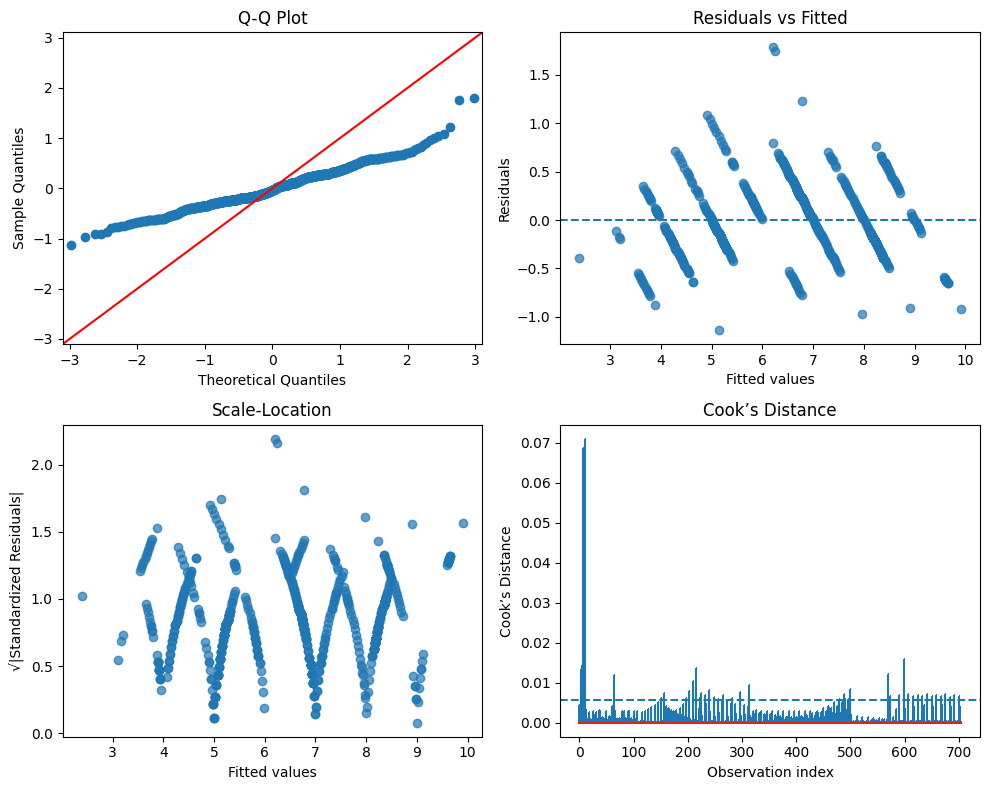

In [11]:
resid_plot(model1_formula_fit)

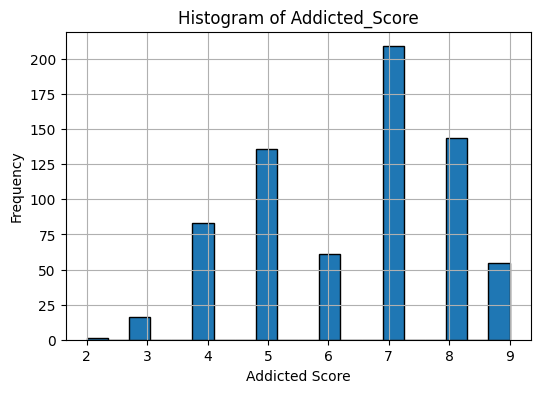

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(df['Addicted_Score'], bins=20, edgecolor='black')
plt.title("Histogram of Addicted_Score")
plt.xlabel("Addicted Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Gausian Mixture Method 
   - `Addicted_Score` 기준으로 2개의 그룹으로 분류:
     - Group 0: 중독 낮음 (N=236)
     - Group 1: 중독 높음 (N=469)

In [ ]:
gmm = GaussianMixture(n_components=2, random_state=42)
df['GMM_Group'] = gmm.fit_predict(df[['Addicted_Score']])

## Group-specific Regression Analysis after GMM

GMM(Gaussian Mixture Model)을 활용하여 분리한 그룹에 대해 각각 회귀 분석을 진행하였다.
각 그룹에 대해 동일한 회귀식을 적용하였으며, 이후 회귀 계수를 비교함으로써 독립 변수와 종속 변수의 관계를 파악했다.
회귀 계수 비교는 z-test와 유사한 방법($\frac{b_1 - b_2}{\sqrt{se_1^2 + se_2^2}}$)으로 진행했다.

분석은 다음 순서로 진행하였다. 

1. 수치형 변수로만 회귀
2. 성별 변수를 포함한 회귀
3. 학업 성과 영향 여부 변수를 포함한 회귀
4. 학업 수준 변수를 포함한 회귀

In [13]:
reg_vars = ['Mental_Health_Score', 'Conflicts_Over_Social_Media',
            'Sleep_Hours_Per_Night', 'Avg_Daily_Usage_Hours', 'Age']

group0 = df[df['GMM_Group'] == 0]
group1 = df[df['GMM_Group'] == 1]


X0 = sm.add_constant(group0[reg_vars])
y0 = group0['Addicted_Score']

X1 = sm.add_constant(group1[reg_vars])
y1 = group1['Addicted_Score']

model0 = sm.OLS(y0, X0).fit()
model1 = sm.OLS(y1, X1).fit()

# 회귀 계수 비교 (계수 차이 검정 - z-test 유사)
# 계산: (b1 - b2) / sqrt(se1^2 + se2^2)
coef_diff = model0.params - model1.params
se_diff = (model0.bse ** 2 + model1.bse ** 2) ** 0.5
z_scores = coef_diff / se_diff
p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

comparison_df = pd.DataFrame({
    'Variable': coef_diff.index,
    'Coef_Diff': coef_diff.values,
    'Z-Score': z_scores,
    'P-Value': p_values
})

comparison_df.reset_index(drop=True)

,Variable,Coef_Diff,Z-Score,P-Value
0,const,0.036070,0.049258,9.607133e-01
1,Mental_Health_Score,-0.281519,-4.975124,6.520589e-07
2,Conflicts_Over_Social_Media,0.125223,1.789641,7.351161e-02
3,Sleep_Hours_Per_Night,0.027682,0.618541,5.362187e-01
4,Avg_Daily_Usage_Hours,-0.096450,-2.153770,3.125825e-02
5,Age,0.054669,3.121060,1.802016e-03


In [14]:
print(model0.pvalues)
print("            ")
print(model1.pvalues)

const                          2.722547e-40
Mental_Health_Score            3.031636e-42
Conflicts_Over_Social_Media    1.994067e-20
Sleep_Hours_Per_Night          2.795860e-04
Avg_Daily_Usage_Hours          7.247532e-01
Age                            2.001210e-02
dtype: float64
            
const                          3.302736e-81
Mental_Health_Score            2.598108e-43
Conflicts_Over_Social_Media    7.264723e-26
Sleep_Hours_Per_Night          1.379294e-13
Avg_Daily_Usage_Hours          4.906118e-04
Age                            3.971120e-02
dtype: float64


In [15]:
report_df = pd.DataFrame({
    'Group': ['GMM Group 0', 'GMM Group 1'],
    'Sample Size': [len(group0), len(group1)],
    'R-squared': [model0.rsquared, model1.rsquared],
    'Mental_Health Coef': [model0.params['Mental_Health_Score'], model1.params['Mental_Health_Score']],
    'Conflict Coef': [model0.params['Conflicts_Over_Social_Media'], model1.params['Conflicts_Over_Social_Media']]
})

report_df.reset_index(drop=True)

,Group,Sample Size,R-squared,Mental_Health Coef,Conflict Coef
0,GMM Group 0,236,0.824165,-0.782232,0.580838
1,GMM Group 1,469,0.862676,-0.500714,0.455615


### 1. 수치형 변수(Mental Health, Conflict, Usage Hours, Age 포함) 회귀 분석 결과

- Group 0(중독 낮음)에서 정신건강 점수의 부적 영향력이 훨씬 큼 → 정신적으로 안정된 학생일수록 중독에서 더욱 자유로움
- SNS 사용 시간이 높은 중독 그룹에서 중독 점수에 더 큰 영향을 미침
- 나이는 높은 중독 그룹에서 중독 점수를 더 낮추는 경향

In [16]:
cat_vars1 = ['Age', 'Gender', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
            'Mental_Health_Score', 'Conflicts_Over_Social_Media']

group0 = df[df['GMM_Group'] == 0]
group1 = df[df['GMM_Group'] == 1]


X0 = pd.get_dummies(group0[cat_vars1])
X0 = sm.add_constant(X0.astype(float))
y0 = group0['Addicted_Score']

X1 = pd.get_dummies(group1[cat_vars1])
X1 = sm.add_constant(X1.astype(float))
y1 = group1['Addicted_Score']

gender_model0 = sm.OLS(y0, X0).fit()
gender_model1 = sm.OLS(y1, X1).fit()

coef_diff = gender_model0.params - gender_model1.params
se_diff = (gender_model0.bse ** 2 + gender_model1.bse ** 2) ** 0.5
z_scores = coef_diff / se_diff
p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

gender_comparison_df = pd.DataFrame({
    'Variable': coef_diff.index,
    'Coef_Diff': coef_diff.values,
    'Z-Score': z_scores,
    'P-Value': p_values
})

gender_comparison_df.dropna(axis=0).reset_index(drop=True).sort_values("Coef_Diff", key=np.abs, ascending=False)

,Variable,Coef_Diff,Z-Score,P-Value
4,Mental_Health_Score,-0.286187,-5.028398,4.945951e-07
5,Conflicts_Over_Social_Media,0.122351,1.742046,8.150040e-02
2,Avg_Daily_Usage_Hours,-0.097132,-2.164400,3.043366e-02
1,Age,0.060930,3.038488,2.377686e-03
0,const,-0.041202,-0.082765,9.340385e-01
7,Gender_Male,-0.038588,-0.151024,8.799568e-01
3,Sleep_Hours_Per_Night,0.028826,0.642958,5.202516e-01
6,Gender_Female,-0.002614,-0.010662,9.914931e-01


In [17]:
print(gender_model0.pvalues)
print("            ")
print(gender_model1.pvalues)

const                          9.284900e-39
Age                            1.465422e-02
Avg_Daily_Usage_Hours          7.122043e-01
Sleep_Hours_Per_Night          3.179936e-04
Mental_Health_Score            4.235684e-42
Conflicts_Over_Social_Media    3.440992e-20
Gender_Female                  8.836169e-40
Gender_Male                    2.926340e-37
dtype: float64
            
const                          1.027737e-78
Age                            7.144387e-02
Avg_Daily_Usage_Hours          5.240078e-04
Sleep_Hours_Per_Night          1.666872e-13
Mental_Health_Score            3.874843e-43
Conflicts_Over_Social_Media    1.395615e-25
Gender_Female                  1.195216e-80
Gender_Male                    2.196479e-75
dtype: float64


In [18]:
gender_report_df = pd.DataFrame({
    'Group': ['GMM Group 0', 'GMM Group 1'],
    'Sample Size': [len(group0), len(group1)],
    'R-squared': [gender_model0.rsquared, gender_model1.rsquared],
    'Mental_Health Coef': [gender_model0.params['Mental_Health_Score'], gender_model1.params['Mental_Health_Score']],
    'Sleep_Hours Coef': [gender_model0.params['Sleep_Hours_Per_Night'], gender_model1.params['Sleep_Hours_Per_Night']],
    'Conflict Coef': [gender_model0.params['Conflicts_Over_Social_Media'], gender_model1.params['Conflicts_Over_Social_Media']],
    'Gender_Male Coef': [gender_model0.params['Gender_Male'], gender_model1.params['Gender_Male']],
    'Gender_Female Coef': [gender_model0.params['Gender_Female'], gender_model1.params['Gender_Female']]
})

gender_report_df.reset_index(drop=True)

,Group,Sample Size,R-squared,Mental_Health Coef,Sleep_Hours Coef,Conflict Coef,Gender_Male Coef,Gender_Female Coef
0,GMM Group 0,236,0.824718,-0.786878,-0.141854,0.578027,3.228326,3.263811
1,GMM Group 1,469,0.862676,-0.500691,-0.170680,0.455676,3.266914,3.266425


### 2. 성별(Gender) 포함 회귀 분석 결과

- 성별 변수는 중독 점수에 유의미한 영향 없음 → 본 연구에서는 **남녀 간 중독 정도 차이는 통계적으로 유의하지 않음**
- 정신건강 점수는 여전히 낮은 중독 그룹에서 훨씬 더 큰 부적 효과를 가짐

In [19]:
cat_vars2 = ['Age', 'Affects_Academic_Performance', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
            'Mental_Health_Score', 'Conflicts_Over_Social_Media']

group0 = df[df['GMM_Group'] == 0]
group1 = df[df['GMM_Group'] == 1]


X0 = pd.get_dummies(group0[cat_vars2])
X0 = sm.add_constant(X0.astype(float))
y0 = group0['Addicted_Score']

X1 = pd.get_dummies(group1[cat_vars2])
X1 = sm.add_constant(X1.astype(float))
y1 = group1['Addicted_Score']

perf_model0 = sm.OLS(y0, X0).fit()
perf_model1 = sm.OLS(y1, X1).fit()

coef_diff = perf_model0.params - perf_model1.params
se_diff = (perf_model0.bse ** 2 + perf_model1.bse ** 2) ** 0.5
z_scores = coef_diff / se_diff
p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

perf_comparison_df = pd.DataFrame({
    'Variable': coef_diff.index,
    'Coef_Diff': coef_diff.values,
    'Z-Score': z_scores,
    'P-Value': p_values
})

perf_comparison_df.dropna(axis=0).reset_index(drop=True).sort_values("Coef_Diff", key=np.abs, ascending=False)

,Variable,Coef_Diff,Z-Score,P-Value
0,Affects_Academic_Performance_No,6.410356,10.327672,0.000000e+00
4,Mental_Health_Score,-0.276371,-4.893397,9.911002e-07
3,Conflicts_Over_Social_Media,0.092437,1.306091,1.915215e-01
2,Avg_Daily_Usage_Hours,-0.089511,-1.999806,4.552127e-02
1,Age,0.055552,3.181140,1.466966e-03
5,Sleep_Hours_Per_Night,0.028564,0.639405,5.225598e-01


In [20]:
print(perf_model0.pvalues)
print("            ")
print(perf_model1.pvalues)

Age                                2.001210e-02
Avg_Daily_Usage_Hours              7.247532e-01
Sleep_Hours_Per_Night              2.795860e-04
Mental_Health_Score                3.031636e-42
Conflicts_Over_Social_Media        1.994067e-20
Affects_Academic_Performance_No    2.722547e-40
dtype: float64
            
const                               1.158240e-82
Age                                 3.180798e-02
Avg_Daily_Usage_Hours               1.357694e-03
Sleep_Hours_Per_Night               7.172399e-14
Mental_Health_Score                 2.157065e-44
Conflicts_Over_Social_Media         1.766648e-27
Affects_Academic_Performance_No     1.247273e-78
Affects_Academic_Performance_Yes    9.514690e-76
dtype: float64


In [21]:
perf_report_df = pd.DataFrame({
    'Group': ['GMM Group 0', 'GMM Group 1'],
    'Sample Size': [len(group0), len(group1)],
    'R-squared': [perf_model0.rsquared, perf_model1.rsquared],
    'Mental_Health Coef': [perf_model0.params['Mental_Health_Score'], perf_model1.params['Mental_Health_Score']],
    'Sleep_Hours Coef': [perf_model0.params['Sleep_Hours_Per_Night'], perf_model1.params['Sleep_Hours_Per_Night']],
    'Conflict Coef': [perf_model0.params['Conflicts_Over_Social_Media'], perf_model1.params['Conflicts_Over_Social_Media']],
    'Age Coef': [perf_model0.params['Age'], perf_model1.params['Age']],
    'Performance_No Coef': [perf_model0.params['Affects_Academic_Performance_No'], perf_model1.params['Affects_Academic_Performance_No']]
})

perf_report_df.reset_index(drop=True)

,Group,Sample Size,R-squared,Mental_Health Coef,Sleep_Hours Coef,Conflict Coef,Age Coef,Performance_No Coef
0,GMM Group 0,236,0.824165,-0.782232,-0.143020,0.580838,0.030678,9.834846
1,GMM Group 1,469,0.864966,-0.505861,-0.171584,0.488401,-0.024874,3.424490


### 3. 학업 성과 영향 여부 포함 회귀 분석 결과

- 중독 점수가 높은 그룹은 “SNS가 학업에 영향 없다”고 인식하는 경향 강함 → **자기인식 왜곡** 가능성
- 중독 점수가 낮은 그룹은 학업 영향도, 정신건강 영향도 민감하게 인식하는 경향

In [22]:
cat_vars3 = ['Age', 'Academic_Level', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
            'Mental_Health_Score', 'Conflicts_Over_Social_Media']

group0 = df[df['GMM_Group'] == 0]
group1 = df[df['GMM_Group'] == 1]


X0 = pd.get_dummies(group0[cat_vars3])
X0 = sm.add_constant(X0.astype(float))
y0 = group0['Addicted_Score']

X1 = pd.get_dummies(group1[cat_vars3])
X1 = sm.add_constant(X1.astype(float))
y1 = group1['Addicted_Score']

academic_model0 = sm.OLS(y0, X0).fit()
academic_model1 = sm.OLS(y1, X1).fit()

coef_diff = academic_model0.params - academic_model1.params
se_diff = (academic_model0.bse ** 2 + academic_model1.bse ** 2) ** 0.5
z_scores = coef_diff / se_diff
p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

academic_comparison_df = pd.DataFrame({
    'Variable': coef_diff.index,
    'Coef_Diff': coef_diff.values,
    'Z-Score': z_scores,
    'P-Value': p_values
})

academic_comparison_df.dropna(axis=0).reset_index(drop=True).sort_values("Coef_Diff", key=np.abs, ascending=False)

,Variable,Coef_Diff,Z-Score,P-Value
4,Mental_Health_Score,-0.290282,-5.083225,3.710797e-07
5,Conflicts_Over_Social_Media,0.122512,1.736538,8.246870e-02
2,Avg_Daily_Usage_Hours,-0.103668,-2.283686,2.238998e-02
1,Age,0.067123,2.066999,3.873425e-02
7,Academic_Level_High School,-0.061986,-0.265946,7.902806e-01
0,const,-0.051194,-0.070495,9.437999e-01
8,Academic_Level_Undergraduate,0.033063,0.129145,8.972426e-01
6,Academic_Level_Graduate,-0.022270,-0.071557,9.429542e-01
3,Sleep_Hours_Per_Night,0.018388,0.397040,6.913379e-01


In [23]:
print(academic_model0.pvalues)
print("            ")
print(academic_model1.pvalues)

const                           7.952805e-28
Age                             5.471261e-01
Avg_Daily_Usage_Hours           7.172933e-01
Sleep_Hours_Per_Night           2.963692e-04
Mental_Health_Score             1.690386e-41
Conflicts_Over_Social_Media     3.619284e-20
Academic_Level_Graduate         5.186221e-19
Academic_Level_High School      6.484018e-28
Academic_Level_Undergraduate    1.385404e-24
dtype: float64
            
const                           4.150602e-62
Age                             9.723855e-03
Avg_Daily_Usage_Hours           2.278103e-04
Sleep_Hours_Per_Night           1.494453e-12
Mental_Health_Score             1.984330e-42
Conflicts_Over_Social_Media     6.609827e-26
Academic_Level_Graduate         5.062354e-46
Academic_Level_High School      9.975119e-74
Academic_Level_Undergraduate    9.522075e-60
dtype: float64


In [24]:
academic_report_df = pd.DataFrame({
    'Group': ['GMM Group 0', 'GMM Group 1'],
    'Sample Size': [len(group0), len(group1)],
    'R-squared': [academic_model0.rsquared, academic_model1.rsquared],
    'Mental_Health Coef': [academic_model0.params['Mental_Health_Score'], academic_model1.params['Mental_Health_Score']],
    'Sleep_Hours Coef': [academic_model0.params['Sleep_Hours_Per_Night'], academic_model1.params['Sleep_Hours_Per_Night']],
    'Conflict Coef': [academic_model0.params['Conflicts_Over_Social_Media'], academic_model1.params['Conflicts_Over_Social_Media']],
    'High School Coef': [academic_model0.params['Academic_Level_High School'], academic_model1.params['Academic_Level_High School']],
    'Undergraduate Coef': [academic_model0.params['Academic_Level_Undergraduate'], academic_model1.params['Academic_Level_Undergraduate']],
    'Graduate Coef': [academic_model0.params['Academic_Level_Graduate'], academic_model1.params['Academic_Level_Graduate']]
})

academic_report_df.reset_index(drop=True)

,Group,Sample Size,R-squared,Mental_Health Coef,Sleep_Hours Coef,Conflict Coef,High School Coef,Undergraduate Coef,Graduate Coef
0,GMM Group 0,236,0.824573,-0.784252,-0.148005,0.581765,2.529172,2.534003,2.584873
1,GMM Group 1,469,0.864628,-0.493970,-0.166393,0.459253,2.591158,2.500940,2.607143


### 4. 학업 수준(Academic Level) 포함 회귀 분석 결과

- 학업 수준(고등학생, 학부생, 대학원생)에 따른 중독 점수 영향력 차이는 미미
- 그러나 정신건강 점수의 영향력은 낮은 중독 그룹에서 여전히 더 강하게 나타남

# Conclusion

## Research Summary

1. **정신 건강 점수**는 모든 분석에서 일관되게 소셜미디어 중독 점수에 가장 강력한 부적 영향력을 미침. 특히 중독 수준이 낮은 집단에서 그 영향력이 더욱 두드러짐.
2. **SNS 관련 갈등 경험**은 중독 점수를 높이는 주요 요인으로 작용하며, 두 그룹 모두에서 정(+)의 영향력을 가짐.
3. **수면 시간** 역시 중독 점수와 음의 상관관계를 가지며, 수면 부족이 중독 악화에 기여할 수 있음을 시사함.
4. **성별, 학업 수준, 플랫폼 종류 등은 일부 유의미하지만**, 정신 건강과 갈등 경험에 비해 상대적으로 영향력이 낮음.

## Theoretical implications

- 본 연구는 SNS 중독이 단순히 사용 시간에 의해서가 아니라, **심리사회적 변수(정신 건강, 갈등, 수면)**와 밀접하게 연결되어 있음을 실증적으로 입증
- 특히 **중독 경향이 낮은 집단**은 정신 건강과 수면에 민감하게 반응하므로, 이들에 대한 사전적 예방 조치가 효과적일 수 있음

## Suggestion

- **예방 중심 개입 전략 필요**: 정신 건강 취약 학생을 조기 발견하고, SNS 관련 갈등 조절 교육을 병행할 것
- **중독 고위험군**은 자기 인식 왜곡 경향이 있으므로, 행동 데이터 기반의 간접적 평가와 피드백 설계가 요구됨
- **학생 대상 프로그램 설계 시**, 단일 요인(시간 차단 등)에만 의존하지 말고, 정서·관계적 요소를 복합적으로 고려할 것